In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Load the data (replace with your actual file path)
df = pd.read_csv(r'C:\Users\Rithv\Github\ML_Project\G_007_053_055_132_199\code\Phase_1\train_FD001_phase_1.csv')

# Initial data cleaning (NOTE: Engine no is dropped here)
#df = df.drop('Unnamed: 0', axis=1)
df = df.drop(["Engine no"] + [f"Operating {i}" for i in range(1, 4)] + [f"Sensor {i}" for i in [1, 5, 6, 8, 10, 13, 16, 18, 19]], axis=1)


In [32]:
#pd.set_option('display.max_columns', None)
df.head()


,Num cycles,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 9,Sensor 11,Sensor 12,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Stage
0,2,642.15,1591.82,1403.14,553.75,9044.07,47.49,522.28,8131.49,8.4318,392,39.00,23.4236,0
1,3,642.35,1587.99,1404.20,554.26,9052.94,47.27,522.42,8133.23,8.4178,390,38.95,23.3442,0
2,4,642.35,1582.79,1401.87,554.45,9049.48,47.13,522.86,8133.83,8.3682,392,38.88,23.3739,0
3,5,642.37,1582.85,1406.22,554.00,9055.15,47.28,522.19,8133.80,8.4294,393,38.90,23.4044,0
4,6,642.10,1584.47,1398.37,554.67,9049.68,47.16,521.68,8132.85,8.4108,391,38.98,23.3669,0


In [33]:
def compute_avg_time_to_next_stage_optimized(df):
    df = df.sort_values(['Num cycles'])  # keep your original sort
    df['time_to_next_stage'] = np.nan  # initialize

    avg_time_to_next = {}

    # precompute cycles per stage
    stage_cycles = {
        stage: df.loc[df['Stage'] == stage, 'Num cycles'].values
        for stage in df['Stage'].unique()
    }

    for stage in df['Stage'].unique():
        next_stage = stage + 1
        if next_stage in stage_cycles:
            cycles_stage = stage_cycles[stage]
            cycles_next_stage = stage_cycles[next_stage]
            
            # vectorized broadcasting: compute all pairs difference
            diff_matrix = cycles_next_stage.reshape(1, -1) - cycles_stage.reshape(-1, 1)
            
            # keep only positive diffs
            valid_diffs = diff_matrix[diff_matrix > 0]
            
            if valid_diffs.size > 0:
                avg_time = np.mean(valid_diffs)
                avg_time_to_next[stage] = avg_time

    # assign back to dataframe
    df['time_to_next_stage'] = df['Stage'].map(avg_time_to_next)

    return df


df = compute_avg_time_to_next_stage_optimized(df)
df = df.fillna(0)  # Handle potential NaNs
print("Average time to next stage calculated (WITHOUT Engine no).")

Average time to next stage calculated (WITHOUT Engine no).


In [34]:
# Feature Engineering
for sensor in [f'Sensor {i}' for i in range(2, 22) if f'Sensor {i}' in df.columns]:
    df[f'{sensor}_rolling_mean_10'] = df[sensor].rolling(window=10, min_periods=1).mean()
    df[f'{sensor}_diff'] = df[sensor].diff()
    df[f'{sensor}_lag_1'] = df[sensor].shift(1)

df = df.fillna(0)
print("Feature engineering done (WITHOUT Engine no - CAUTION!).")

Feature engineering done (WITHOUT Engine no - CAUTION!).


In [35]:
# Data Preprocessing: Scaling
numerical_cols = [col for col in df.columns if df[col].dtype != 'object' and col not in ['Num cycles', 'time_to_next_stage', 'Stage']]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Data scaled.")

Data scaled.


In [36]:
# Data Preparation for Modeling
X = df.drop(['time_to_next_stage', 'Num cycles', 'Stage'], axis=1)
y = df['time_to_next_stage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared for modeling.")

Data prepared for modeling.


In [37]:
print("X_train shape:", X_train.shape)

X_train shape: (16504, 48)


RMSE: 10.247284853648168, MAE: 6.610676435321256, R-squared: 0.8239223534008356


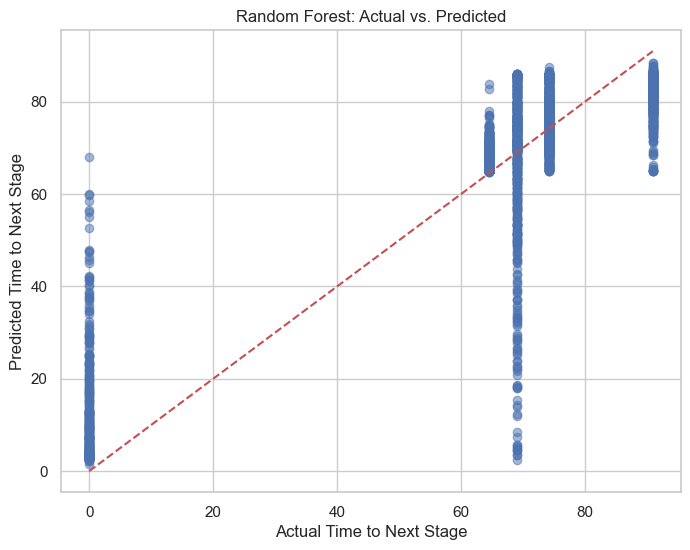

In [38]:
# Model: Random Forest Regressor (Basic)
rf = RandomForestRegressor(
    n_estimators=50,        # fewer trees (50 instead of 100) → faster
    max_depth=10,           # limit depth → faster, prevents overfitting
    n_jobs=-1,              # parallel processing → use all CPU cores
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


print(f"RMSE: {rmse_rf}, MAE: {mae_rf}, R-squared: {r2_rf}")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("Random Forest: Actual vs. Predicted")
plt.show()

In [39]:
print(df['time_to_next_stage'].min(), df['time_to_next_stage'].max())

0.0 90.89539293307864


In [40]:
# Model: Ridge Regression (Basic)
ridge = Ridge(random_state=42)  # Basic parameters
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Trained (Basic)")

print(f"RMSE: {rmse_ridge}, MAE: {mae_ridge}, R-squared: {r2_ridge}")
print("The reason we get such a bad value of R-Squared is because of the skewness of the target value")

Ridge Regression Trained (Basic)
RMSE: 21.73938620936073, MAE: 17.20804751910605, R-squared: 0.20753304209828116
The reason we get such a bad value of R-Squared is because of the skewness of the target value


RMSE: 11.04582978339315, MAE: 6.6826756470985265, R-squared: 0.7954105192621133


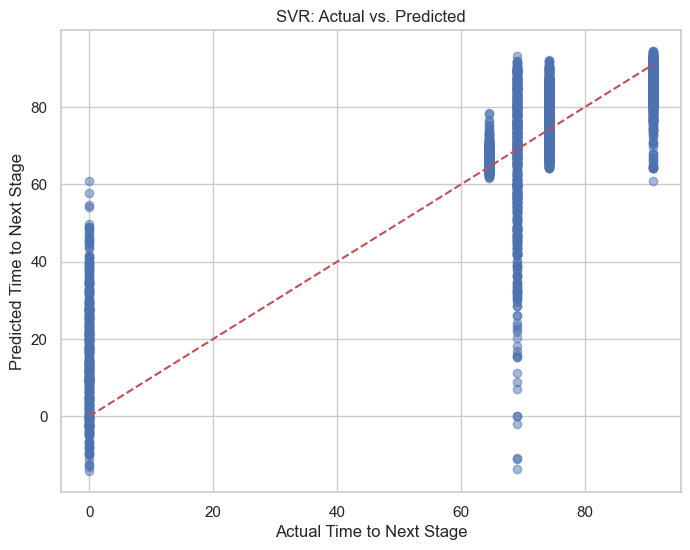

In [41]:
# Model: Support Vector Regression (SVR) (Basic)
svr = SVR()  # Basic parameters
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)


print(f"RMSE: {rmse_svr}, MAE: {mae_svr}, R-squared: {r2_svr}")
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("SVR: Actual vs. Predicted")
plt.show()

In [42]:
# Model Comparison
print("\nModel Comparison:")
print(f"Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}, R-squared: {r2_rf}")
print(f"Ridge Regression - RMSE: {rmse_ridge}, MAE: {mae_ridge}, R-squared: {r2_ridge}")
print(f"SVR - RMSE: {rmse_svr}, MAE: {mae_svr}, R-squared: {r2_svr}")


Model Comparison:
Random Forest - RMSE: 10.247284853648168, MAE: 6.610676435321256, R-squared: 0.8239223534008356
Ridge Regression - RMSE: 21.73938620936073, MAE: 17.20804751910605, R-squared: 0.20753304209828116
SVR - RMSE: 11.04582978339315, MAE: 6.6826756470985265, R-squared: 0.7954105192621133


In [43]:
X_test.head()

,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 9,Sensor 11,Sensor 12,Sensor 14,Sensor 15,Sensor 17,...,Sensor 15_lag_1,Sensor 17_rolling_mean_10,Sensor 17_diff,Sensor 17_lag_1,Sensor 20_rolling_mean_10,Sensor 20_diff,Sensor 20_lag_1,Sensor 21_rolling_mean_10,Sensor 21_diff,Sensor 21_lag_1
137,0.858020,0.286544,0.407294,-0.132943,-0.925343,0.482346,-0.519907,-0.984632,0.532022,0.509632,...,0.349484,1.003589,-0.000082,0.257070,-0.405780,0.634246,-0.198082,-0.288972,1.263531,-0.520069
9925,-0.361938,-0.780141,-2.084813,1.301980,0.020656,-1.389703,1.161332,-0.118104,-0.507848,-0.781740,...,0.115691,-0.922396,0.563127,-0.696770,0.836931,0.585464,0.509393,0.885796,-0.871171,0.866984
18471,-0.421936,2.121437,1.449468,-1.341893,-0.428569,0.819315,-1.455435,-0.544815,0.971967,0.509632,...,-0.427913,-0.212823,1.689544,-0.696770,0.511255,-1.219462,0.171035,0.336898,-1.160526,0.223215
18332,-0.341939,-0.682280,0.057310,0.183418,-0.657257,-0.191592,0.456296,-0.710467,0.113408,0.509632,...,0.013855,-0.010088,0.563127,-0.060877,-0.054393,0.878155,-0.444161,-0.340191,-0.857315,0.408908
19502,0.198043,-1.163430,0.459514,-0.969039,1.080772,0.257700,-0.221623,0.954964,-0.126562,0.509632,...,0.751091,1.713162,-1.126499,0.892963,-1.425659,0.048865,-0.474920,-1.796806,0.534032,-0.488779


In [44]:
import joblib

# Save models
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(ridge, 'ridge_model.pkl')
joblib.dump(svr, 'svr_model.pkl')

# Save test data
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Models and test data saved successfully.")


Models and test data saved successfully.


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare data for classification
X_cls = df.drop(['Stage', 'time_to_next_stage', 'Num cycles'], axis=1)
y_cls = df['Stage']

# Split data for classifier
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Initialize classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)

# Evaluate classifier
y_pred_cls = clf.predict(X_test_cls)
print("\nClassifier Evaluation:")
print(confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

# Save classifier
joblib.dump(clf, 'classifier_model.pkl')
print("✅ Classifier model saved as classifier_model.pkl")



Classifier Evaluation:
[[855 115   0   0   0]
 [ 90 854 114   0   0]
 [ 11 130 924  56   0]
 [  0   6  82 459  36]
 [  0   0   0  34 360]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       970
           1       0.77      0.81      0.79      1058
           2       0.82      0.82      0.82      1121
           3       0.84      0.79      0.81       583
           4       0.91      0.91      0.91       394

    accuracy                           0.84      4126
   macro avg       0.85      0.84      0.84      4126
weighted avg       0.84      0.84      0.84      4126

✅ Classifier model saved as classifier_model.pkl
